In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import StandardScaler as stscale
from sklearn.preprocessing import Imputer
#import scipy.stats as stats
from scipy import stats, linalg

import diff_classifier.aws as aws


# Importing and Scaling Data

In [2]:
filename = 'CatWalk_cleaned.csv'
folder = 'ferret_tracking'
aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name='ccurtis.data')

In [23]:
nonnum = ['Litter', 'Ferret', 'Number', 'Sex', 'Rx', 'Experiment', 'Trial']

fstats = pd.read_csv(filename, encoding = "ISO-8859-1", )
fstats_num = fstats.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()

# Imputation of missing values

In [16]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(fstats_raw)
fstats_clean = imp.transform(fstats_raw)

In [18]:
scaler = stscale()
scaler.fit(fstats_clean)
fstats_scaled = scaler.transform(fstats_clean)

# Bartlett Test

In [26]:
fstats_list = []
for num in range(0, fstats_scaled.shape[0]):
    fstats_list.append(fstats_scaled[num, :])
    
stats.bartlett(*fstats_list)

BartlettResult(statistic=19487.526045226525, pvalue=0.0)

We accept the null hypothesis that all input samples are from populations with equal variances.

# Kaiser-Meyer-Olkin (KMO) Measure

* 0.00 to 0.49 unacceptable.
* 0.50 to 0.59 miserable.
* 0.60 to 0.69 mediocre.
* 0.70 to 0.79 middling.
* 0.80 to 0.89 meritorious.
* 0.90 to 1.00 marvelous.

In [29]:
#Correlation matrix and the partial covariance matrix.
corrmatrix = np.corrcoef(fstats_scaled.transpose())
pcorr = partial_corr(fstats_scaled)

#Calculation of the KMO statistic
matrix = corrmatrix*corrmatrix
rows = matrix.shape[0]
cols = matrix.shape[1]
rij = 0
uij = 0
for row in range(0, rows):
    for col in range(0, cols):
        if not row == col:
            rij = rij + matrix[row, col]
            uij = uij + pcorr[row, col]

mo = rij/(rij+uij)
print(mo)

0.828032939801


We got middling results with our sampling. Will proceed regardless.

# PCA Analysis

In [ ]:
# pca1 = pca(n_components=5)
# pca1.fit(fstats_raw)

# print(pca1.explained_variance_ratio_) 
# print(pca1.singular_values_)  

In [146]:
pca1 = pca(n_components=21)
pca1.fit(fstats_scaled)

print('Largest eigenvalues of covariance matrix: {}'.format(pca1.explained_variance_))
print('Percent explained variance: {}'.format(pca1.explained_variance_ratio_)) 
#print(pca1.singular_values_)  

Largest eigenvalues of covariance matrix: [ 58.91769289  47.56345315  40.51355471  27.87723773  17.00772312
  10.89014937  10.19005992   8.3222181    7.2144959    7.0844755
   5.92335972   5.65725643   5.22248754   4.92881      4.67545319
   4.49462964   3.83114012   3.78170005   3.4764156    3.31335063
   3.04397039]
Percent explained variance: [ 0.16734605  0.13509619  0.11507211  0.07918073  0.04830765  0.03093168
  0.0289432   0.0236379   0.02049159  0.02012229  0.01682433  0.01606851
  0.01483362  0.01399948  0.01327986  0.01276626  0.01088173  0.0107413
  0.00987419  0.00941103  0.0086459 ]


In [147]:
x = 0
for i in range(0, 20):
    x = x + pca1.explained_variance_ratio_[i]
    print('{} component: {}'.format(i, x))

0 component: 0.16734605207833209
1 component: 0.30244224674803477
2 component: 0.417514360119534
3 component: 0.49669508577011606
4 component: 0.5450027363088854
5 component: 0.5759344210751297
6 component: 0.6048776164824877
7 component: 0.6285155132770839
8 component: 0.649007106680343
9 component: 0.6691293984260289
10 component: 0.6859537310758095
11 component: 0.7020222409306711
12 component: 0.7168558609897414
13 component: 0.7308553381428616
14 component: 0.7441351967820046
15 component: 0.7569014557462357
16 component: 0.7677831814581941
17 component: 0.7785244807730506
18 component: 0.7883986696114526
19 component: 0.7978096991454107


We picked components that met the following criteria:

* Eigenvalues greater than 1
* Percent explained variance cutoff of 80%

This gave the first twenty-one components.

In [148]:
primary = 4
comps = pca1.components_
components = pd.DataFrame(comps.transpose())
highest = components[primary].as_matrix().argsort()[-5:][::-1]
highest

array([326, 327, 181, 344, 174])

In [149]:
prim_comps = {}
prim_vals = {}
comps = pca1.components_
components = pd.DataFrame(comps.transpose())
for num in range(0, 21):
    highest = np.abs(components[num]).as_matrix().argsort()[-5:][::-1]
    pels = []
    prim_vals[num] = components[num].as_matrix()[highest]
    for col in highest:
        pels.append(fstats_num.columns[col])
    prim_comps[num] = pels
    
prcs = pd.DataFrame.from_dict(prim_comps)

In [150]:
primary = 0
prcs[primary]

0    Average Forepaw Step Cycle
1       Avg Rear Paw Stand time
2         LF_StepCycle_(s)_Mean
3             LH_Stand_(s)_Mean
4               LH_Stand_(s)_SD
Name: 0, dtype: object

In [151]:
prim_vals[1]

array([-0.11734691,  0.1135287 ,  0.1107456 ,  0.10666691,  0.10268627])

In [144]:
for comp in prim_vals:
    print(prim_vals[comp])

[ 0.12585062  0.12578915  0.12528142  0.12526278  0.12510774]
[-0.11734691  0.1135287   0.1107456   0.10666691  0.10268627]
[ 0.11965723  0.11761055  0.11738999  0.11650192  0.11611267]
[-0.1409732  -0.13860589 -0.12924686 -0.12666095 -0.12501903]
[-0.18754886 -0.1786311  -0.13829549 -0.13410961 -0.13364204]
[-0.18159186 -0.16820298 -0.16545646 -0.1560798  -0.15281286]
[ 0.15900533 -0.15294985  0.13658362 -0.1359857  -0.13507921]
[ 0.14761467  0.14148982  0.14001785 -0.13991508  0.13856444]
[-0.17537838  0.15727359 -0.1488349   0.1461936   0.14478125]
[-0.18700369 -0.17935522  0.16842285  0.16544311 -0.15566591]
[-0.17783495  0.17622779  0.1690658  -0.16840766 -0.16706309]
[-0.15127504 -0.14658922 -0.13908423  0.13068086 -0.12811364]
[ 0.21748288 -0.2145846   0.20775654  0.20133217 -0.18185288]
[-0.18412506  0.18072506  0.1765859  -0.17376832  0.16327458]
[ 0.19901917  0.18668612 -0.18426906  0.17677705 -0.16645441]
[ 0.27956354  0.27515469  0.22616957 -0.19146745  0.18497272]
[ 0.2097

In [145]:
for num in prcs:
    print(prcs[num])

0    Average Forepaw Step Cycle
1       Avg Rear Paw Stand time
2         LF_StepCycle_(s)_Mean
3             LH_Stand_(s)_Mean
4               LH_Stand_(s)_SD
Name: 0, dtype: object
0              StepSequence_AB_(%)
1          OtherStatistics_Cadence
2    Run_Average_Speed_(cm/s)_Mean
3         LH_BodySpeed_(cm/s)_Mean
4         RF_BodySpeed_(cm/s)_Mean
Name: 1, dtype: object
0    LF_MaxContactMeanIntensity_Mean
1    RF_MaxContactMeanIntensity_Mean
2              RF_MeanIntensity_Mean
3              RH_MeanIntensity_Mean
4    RH_MaxContactMeanIntensity_Mean
Name: 2, dtype: object
0    LH_StrideLength_(cm)_Mean
1    LH_SwingSpeed_(cm/s)_Mean
2          Front Stride Length
3    LF_StrideLength_(cm)_Mean
4    RH_SwingSpeed_(cm/s)_Mean
Name: 3, dtype: object
0    Avg Adjusted Front Paw Area
1     Avg Adjusted Hind Paw Area
2             Avg Front Paw Area
3       LF_PrintArea_(cmÂ²)_Mean
4       RF_PrintArea_(cmÂ²)_Mean
Name: 4, dtype: object
0                    Avg Print Position
1    

In [152]:
fstats_pca = pd.DataFrame(pca1.transform(fstats_scaled))

In [155]:
fstats_avg = np.mean(fstats_pca, axis=0)

In [160]:
fstats_num.columns

Index(['Weight', 'Time_Point', 'NumberOfRunsUsedForCalculatingTrialStatistics',
       'Run_Duration_(s)_Mean', 'Run_Duration_(s)_SD',
       'Run_Average_Speed_(cm/s)_Mean', 'Run_Average_Speed_(cm/s)_SD',
       'Run_Maximum_Variation_(%)_Mean', 'Run_Maximum_Variation_(%)_SD',
       'RF_Stand_(s)_Mean',
       ...
       'Average Hindpaw Step Cycle', 'Front Stride Length',
       'Hind Stride Length', 'Avg Stride Length', 'Stride Length SD',
       'Stride Length CoV', 'Hindpaw Mean Intensity/Area/g', 'Avg Swing Speed',
       'Avg Swing Speed SD', 'Swing Speed CoV'],
      dtype='object', length=350)

In [168]:
fstats_final = pd.concat([fstats[nonnum], fstats_pca], axis=1)

In [207]:
test = np.mean(fstats_final[fstats_final['Sex']=='M'].drop(nonnum, axis=1).as_matrix(), axis=0)
test1 = np.mean(fstats_final[fstats_final['Sex']=='F'].drop(nonnum, axis=1).as_matrix(), axis=0)

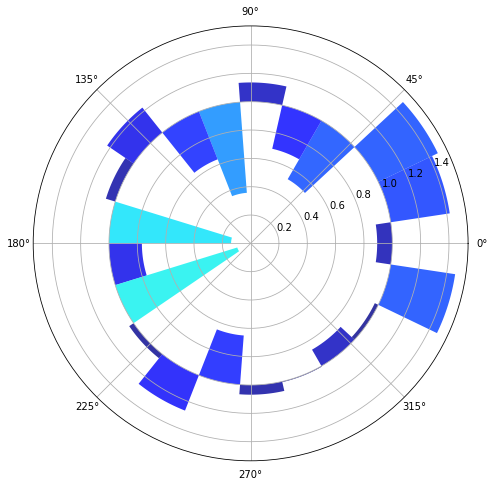

In [198]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))

N = 21
bottom = 1
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = test #max_height*np.random.rand(N) #Edit this line with values. Should have 21.
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(np.abs(r / 2.5)))
    bar.set_alpha(0.8)

plt.show()

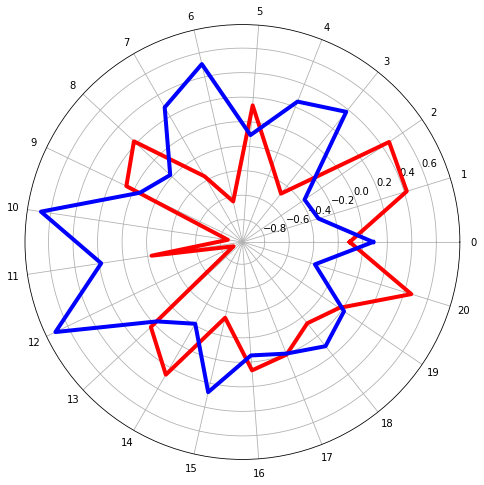

In [225]:
fig = plt.figure(figsize=(8, 8))

N = 21
bottom = 1
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N+1, endpoint=True)
radii = np.append(test, test[0]) #max_height*np.random.rand(N) #Edit this line with values. Should have 21.
radii1 = np.append(test1, test1[0])
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.plot(theta, radii, linewidth=4, color='r')
bars1 = ax.plot(theta, radii1, linewidth=4, color='b')

# # Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.jet(np.abs(r / 2.5)))
#     bar.set_alpha(0.8)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 21, endpoint=False))
ax.set_xticklabels(list(range(0, 21)))
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [28]:
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.

    Partial Correlation in Python (clone of Matlab's partialcorr)

    This uses the linear regression approach to compute the partial 
    correlation (might be slow for a huge number of variables). The 
    algorithm is detailed here:

        http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

    Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
    the algorithm can be summarized as

        1) perform a normal linear least-squares regression with X as the target and Z as the predictor
        2) calculate the residuals in Step #1
        3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
        4) calculate the residuals in Step #3
        5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 

        The result is the partial correlation between X and Y while controlling for the effect of Z


    Date: Nov 2014
    Author: Fabian Pedregosa-Izquierdo, f@bianp.net
    Testing: Valentina Borghesani, valentinaborghesani@gmail.com

    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable


    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr